In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.0
torch.manual_seed(1337)

In [3]:
stoi = {
    ' ': 30,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11,
    'l': 12,
    'm': 13,
    'n': 14,
    'o': 15,
    'p': 16,
    'q': 17,
    'r': 18,
    's': 19,
    't': 20,
    'u': 21,
    'v': 22,
    'w': 23,
    'x': 24,
    'y': 25,
    'z': 26,
    '#': 27,
    '$': 28,
    '@': 29,
    '%': 0
}
# '# = is to'
# '$ = as'
# '@ = end token'
# '% = padding at the end to make it block size length'
vocab_size = len(stoi)

itos = {v: k for k, v in stoi.items()}

# def tokenize(text):
#     return [CHAR_TO_TOKEN[c] for c in text]

# def detokenize(tokens):
#     return ''.join([TOKEN_TO_CHAR[t] for t in tokens])

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [4]:
def load_word_pairs(csv_file, stoi):
    word_pairs = []
    with open(csv_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                singular = parts[0].strip()
                plural = parts[1].strip()

                if all(c in stoi for c in singular) and all(c in stoi for c in plural) and len(singular) + len(plural) <= 20:
                    word_pairs.append((singular, plural))
    return word_pairs

In [5]:
noun_pairs = load_word_pairs("nouns.csv", stoi)
print(noun_pairs[100])

np.random.shuffle(noun_pairs)
n = int(0.9 * len(noun_pairs)) # first 90% will be train, rest val
train_data = noun_pairs[:n]
val_data = noun_pairs[n:]

test_data = load_word_pairs("verbs.csv", stoi)
print("train: ", len(train_data),"| val: ", len(val_data), "| test: ", len(test_data))

('abbr', 'abbrs')
train:  60265 | val:  6697 | test:  175


In [6]:
def get_context_examples(split):
    '''
    Data is of the form:
    %%%% singular $ plural # singular $ part of a plural

    We pad with %%% to keep the size correct

    For example:
    x = fox$foxes#dog$do%%%%%%%
    y = ox$foxes#dog$dog%%%%%%%
    '''

    data = train_data if split == 'train' else val_data
    n = len(data)
    s1, p1 = data[np.random.randint(n)]
    s2, p2 = data[np.random.randint(n)]
    window = np.random.randint(len(p2)+1)
    p2 += '@'
    x = s1 + '#' + p1 + '$' + s2 + '#' + p2[:window]
    y = s1[1:] + '#' + p1 + '$' + s2 + '#' + p2[:window + 1]
    x = torch.tensor(encode(x))
    y = torch.tensor(encode(y))
    return x, y

def get_batch(split):
    data = train_data if split == 'train' else val_data
    x = torch.zeros((batch_size, block_size), dtype=int)
    y = torch.zeros((batch_size, block_size), dtype=int)
    mask = torch.zeros((batch_size, block_size), dtype=torch.bool)


    for i in range(batch_size):
        xi, yi = get_context_examples(split)
        x[i, :len(xi)] = xi  # Assign values up to the original length
        y[i, :len(yi)] = yi  # The rest will be padded with 0s
        mask[i, :len(xi)] = True  # Set True for actual data tokens

    x, y, mask = x.to(device), y.to(device), mask.to(device)
    return x, y, mask

In [7]:
example = get_context_examples('train')
print(decode(example[0].tolist()))
print(decode(example[1].tolist()))

torchon#torchons$galagid#ga
orchon#torchons$galagid#gal


In [8]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, mask = get_batch(split)
            logits, loss = model(X, Y, mask)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            # Apply the mask before the softmax
            wei = wei.masked_fill(~mask[:, None, :], float('-inf'))

        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        #out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = torch.cat([h(x, mask=mask) for h in self.heads], dim=-1)  # Pass mask

        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask=mask)
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        for block in self.blocks:
          x = block(x, mask=mask)

        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def evaluate(self, data, num_to_evaluate):
        self.eval()
        n = len(data)

        correct = 0
        total = 0
        for _ in range(num_to_evaluate):
            s1, p1 = data[np.random.randint(n)]
            s2, p2 = data[np.random.randint(n)]
            p2 += '@'

            idx = s1 + '#' + p1 + '$' + s2 + '#'
            context = idx[:]
            idx = torch.tensor(encode(idx)).to(device).unsqueeze(0)
            for i in range(len(p2)):
                # crop idx to the last block_size tokens
                idx_cond = idx[:, -block_size:]
                # get the predictions
                logits, loss = self(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = logits.argmax(-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

                if idx_next.item() == stoi['@']:
                  break

            predicted = decode(idx[0].tolist())[-len(p2):]

            print(f"Context: {context}, Prediction: {predicted}, Correct: {p2}")
            if predicted == p2:
                correct += 1
            total += 1

        self.train()
        print(f"Accuracy: {correct}/{total}")

In [9]:
plt.rcParams["figure.figsize"] = (7,4)

def batch_accuracy(logits, targets):
    # logits.argmax returns the index of the max‐prob token
    preds = logits.argmax(-1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    return (preds_flat == targets_flat).float().mean().item()

@torch.no_grad()
def eval_split(split, model, eval_iters=50):
    model.eval()
    losses, accs, per_sample = [], [], []
    for _ in range(eval_iters):
        xb, yb, mask = get_batch(split)
        logits, loss = model(xb, yb, mask)
        losses.append(loss.item())
        accs.append(batch_accuracy(logits, yb))
        per_sample.extend(loss.detach().cpu().flatten().tolist())
    model.train()
    return np.mean(losses), np.mean(accs), per_sample

In [10]:
model = GPTLanguageModel().to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

steps, tr_loss, va_loss = [], [], []
tr_acc , va_acc  = [], []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        tl, ta, _ = eval_split('train', model)
        vl, va, _ = eval_split('val',   model)

        steps.append(iter)
        tr_loss.append(tl); va_loss.append(vl)
        tr_acc.append(ta);  va_acc.append(va)

        print(f"step {iter:5d} | train loss {tl:.4f} acc {ta:.3f} | val loss {vl:.4f} acc {va:.3f}")


    # sample a batch of data
    xb, yb, mask = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
print(model.evaluate(val_data, 100))

10.713631 M parameters
step     0 | train loss 3.6263 acc 0.004 | val loss 3.6294 acc 0.004
step   500 | train loss 0.2826 acc 0.912 | val loss 0.2839 acc 0.911
step  1000 | train loss 0.2645 acc 0.916 | val loss 0.2652 acc 0.916
step  1500 | train loss 0.2540 acc 0.919 | val loss 0.2595 acc 0.918
step  2000 | train loss 0.2476 acc 0.921 | val loss 0.2552 acc 0.919
step  2500 | train loss 0.2411 acc 0.922 | val loss 0.2516 acc 0.920
step  3000 | train loss 0.2387 acc 0.923 | val loss 0.2476 acc 0.921
step  3500 | train loss 0.2337 acc 0.925 | val loss 0.2468 acc 0.922
step  4000 | train loss 0.2322 acc 0.925 | val loss 0.2477 acc 0.921
step  4500 | train loss 0.2253 acc 0.927 | val loss 0.2452 acc 0.922
step  4999 | train loss 0.2222 acc 0.928 | val loss 0.2470 acc 0.922
Context: lim inf#lim infs$clodpole#, Prediction: clodpoles@, Correct: clodpoles@
Context: bothid#bothids$trone#, Prediction: trones@, Correct: trones@
Context: eggnog#eggnogs$eejit#, Prediction: eejits@, Correct: eejit

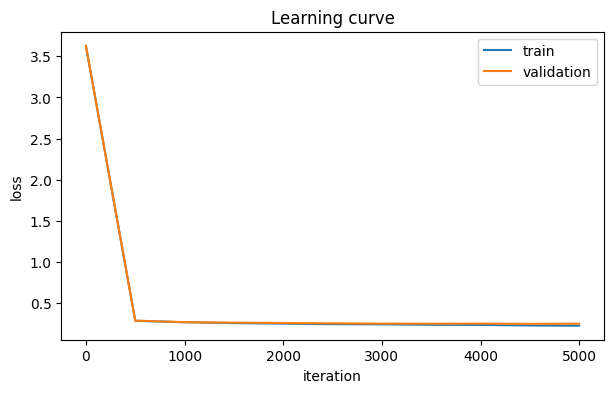

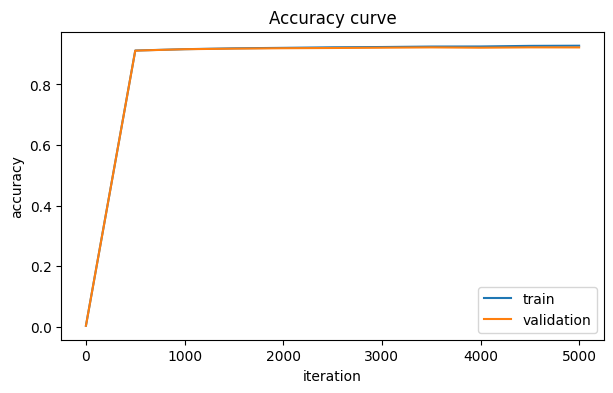

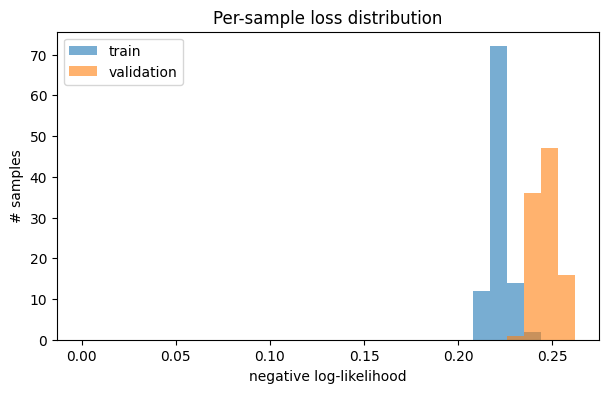

In [11]:
# Learning Curve
plt.figure()
plt.plot(steps, tr_loss, label="train")
plt.plot(steps, va_loss, label="validation")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Learning curve")
plt.legend()
plt.show()

# Accuracy Curve
plt.figure()
plt.plot(steps, tr_acc, label="train")
plt.plot(steps, va_acc, label="validation")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("Accuracy curve")
plt.legend()
plt.show()

# Loss Histogram
_, _, train_losses = eval_split('train', model, eval_iters=100)
_, _,  val_losses  = eval_split('val',   model, eval_iters=100)

plt.figure()
bins = np.linspace(0, max(max(train_losses), max(val_losses)), 30)
plt.hist(train_losses, bins=bins, alpha=0.6, label="train")
plt.hist(val_losses,  bins=bins, alpha=0.6, label="validation")
plt.xlabel("negative log-likelihood")
plt.ylabel("# samples")
plt.title("Per-sample loss distribution")
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), 'model_weights.pth')

In [13]:
model = GPTLanguageModel().to(device)  # Create a new model with the same architecture
model.load_state_dict(torch.load('model_weights.pth'))
print(model.evaluate(val_data, 1))

Context: safe#safes$pawner#, Prediction: pawners@, Correct: pawners@
Accuracy: 1/1
None
